--- Date Consistency Checks ---
[OK] Inpatient dates are consistent.
[OK] Outpatient dates are consistent.
[OK] No claims found after patient death.

--- Granularity Checks ---
1. Beneficiary Table (Unique BeneID?): True
2. Inpatient Table (Unique ClaimID?):  True
3. Outpatient Table (Unique ClaimID?): True
4. Provider Table (Unique Provider?):  True

--- Processed Dataset Head ---
   Provider PotentialFraud  TotalClaims  TotalReimbursement  UniquePatients  \
0  PRV51001             No           25              104640              24   
1  PRV51003            Yes          132              605670             117   
2  PRV51004             No          149               52170             138   
3  PRV51005            Yes         1165              280910             495   
4  PRV51007             No           72               33710              58   

   InpatientCount  AvgClaimCost  ClaimsPerPatient  InpatientRatio  
0               5   4185.600000          1.041667        0.200000  
1   

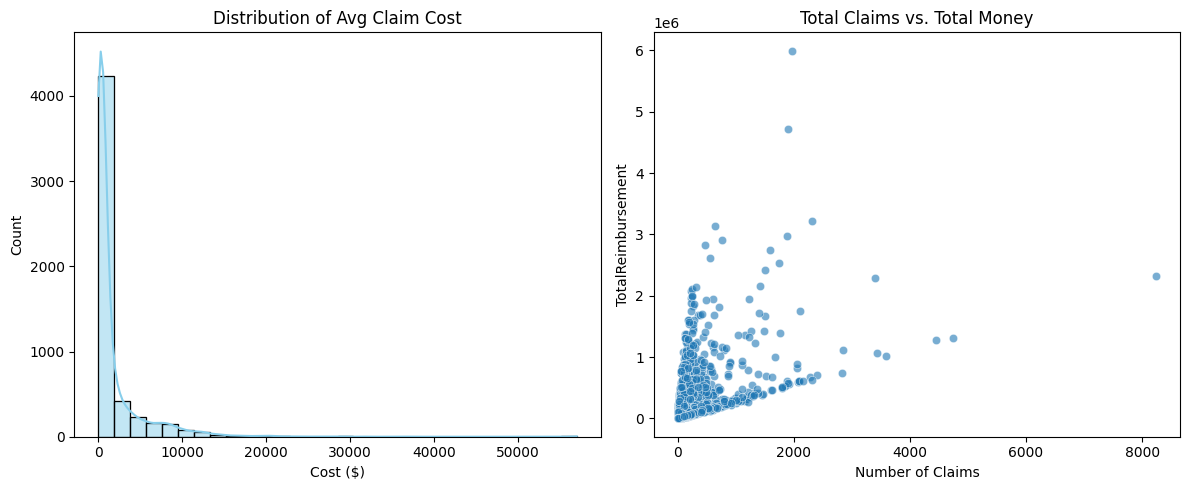

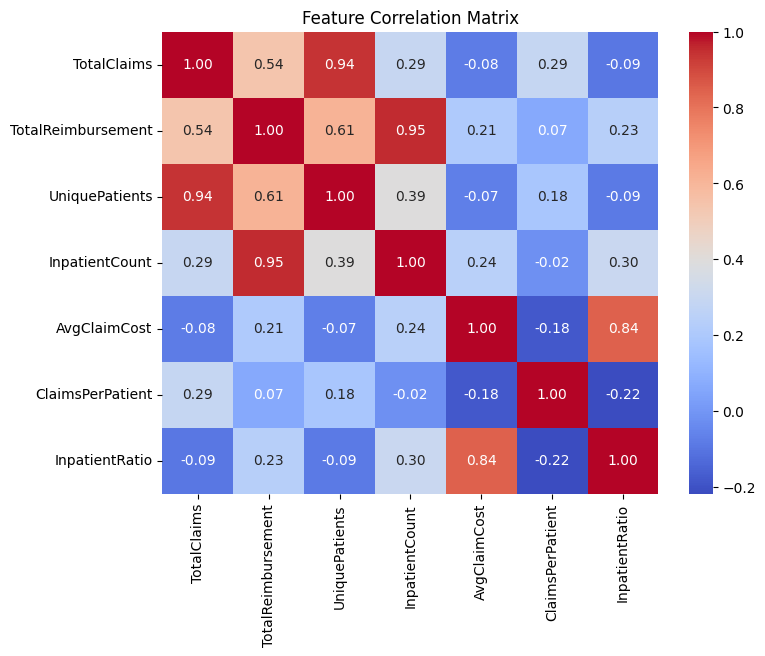


--- Fraud Distribution & Comparison ---


C:\Users\Tarek Metwally\AppData\Local\Temp\ipykernel_14788\1210567999.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Target', data=final_dataset, palette='Set2')


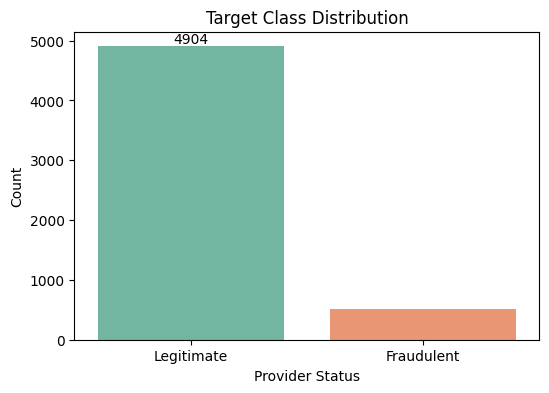

C:\Users\Tarek Metwally\AppData\Local\Temp\ipykernel_14788\1210567999.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y='AvgClaimCost', data=final_dataset, palette='Set2')


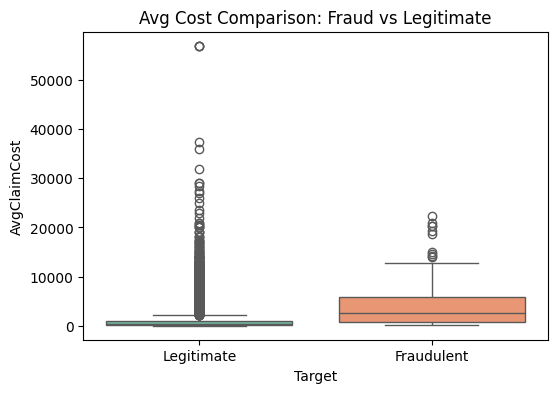

Data saved to 'processed_train_data.csv'.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# IMPORTANT: To see the Fraud Analysis (Section 7), you must load the 'Train' files.
# Currently using 'Test' files as placeholders based on your upload.
bene_df = pd.read_csv('Train_Beneficiarydata.csv')
inp_df  = pd.read_csv('Train_Inpatientdata.csv')
out_df  = pd.read_csv('Train_Outpatientdata.csv')
prov_df = pd.read_csv('Train_labels.csv') 

# --- 2. Handle Inconsistent Values (Data Cleaning) ---
# 1.5.1 Requirement: "Assess data quality... identifying inconsistencies"

# Convert Date Columns to DateTime objects
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'DOB', 'DOD', 'AdmissionDt', 'DischargeDt']
for df in [bene_df, inp_df, out_df]:
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

# Check 1: Date Logic (Start > End)
print("--- Date Consistency Checks ---")
for name, df in [("Inpatient", inp_df), ("Outpatient", out_df)]:
    invalid = df[df['ClaimStartDt'] > df['ClaimEndDt']]
    if len(invalid) > 0:
        print(f"[!] {name}: {len(invalid)} claims have End Date before Start Date.")
    else:
        print(f"[OK] {name} dates are consistent.")

# Check 2: Claims After Death
temp_merge = pd.merge(inp_df, bene_df[['BeneID', 'DOD']], on='BeneID', how='left')
dead_claims = temp_merge[
    (temp_merge['DOD'].notnull()) & 
    (temp_merge['ClaimStartDt'] > temp_merge['DOD'])
]
if len(dead_claims) > 0:
    print(f"[!] Found {len(dead_claims)} claims created after patient death.")
else:
    print("[OK] No claims found after patient death.")


# --- 3. Relationships & Granularity ---
# 1.5.1 Requirement: "Examine relationships between the four datasets"
print("\n--- Granularity Checks ---")
# Check all 4 datasets as required
print(f"1. Beneficiary Table (Unique BeneID?): {bene_df['BeneID'].is_unique}") 
print(f"2. Inpatient Table (Unique ClaimID?):  {inp_df['ClaimID'].is_unique}")   
print(f"3. Outpatient Table (Unique ClaimID?): {out_df['ClaimID'].is_unique}")  
print(f"4. Provider Table (Unique Provider?):  {prov_df['Provider'].is_unique}") 


# --- 4. Merging Strategy ---
# Prepare Claims
inp_df['ClaimType'] = 'Inpatient'
out_df['ClaimType'] = 'Outpatient'
all_claims = pd.concat([inp_df, out_df], axis=0, ignore_index=True)

# Join Beneficiary Details to Claims (One-to-Many)
claims_with_patients = pd.merge(all_claims, bene_df, on='BeneID', how='left')

# Aggregation: Create the "Provider-Level" Modeling Unit
provider_features = claims_with_patients.groupby('Provider').agg({
    'ClaimID': 'count',                       # Total Volume
    'InscClaimAmtReimbursed': 'sum',          # Total Revenue
    'BeneID': 'nunique',                      # Total Unique Patients
    'ClaimType': lambda x: (x=='Inpatient').sum() # Count of Inpatient Claims
}).reset_index()

# Rename for clarity
provider_features.columns = ['Provider', 'TotalClaims', 'TotalReimbursement', 'UniquePatients', 'InpatientCount']

# Final Join: Attach features to the Target Labels (Many-to-One)
final_dataset = pd.merge(prov_df, provider_features, on='Provider', how='left').fillna(0)


# --- 5. Feature Engineering ---
# Create metrics for behavioral comparison
final_dataset['AvgClaimCost'] = final_dataset['TotalReimbursement'] / final_dataset['TotalClaims']
final_dataset['ClaimsPerPatient'] = final_dataset['TotalClaims'] / final_dataset['UniquePatients']
final_dataset['InpatientRatio'] = final_dataset['InpatientCount'] / final_dataset['TotalClaims']

# Handle division by zero
final_dataset = final_dataset.fillna(0)

print("\n--- Processed Dataset Head ---")
print(final_dataset.head())


# --- 6. General Visualizations ---
# 1.5.1 Requirement: "Produce core plots... patterns, distributions"
print("\n--- Generating Exploratory Plots ---")

# A. Distribution of Costs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(final_dataset['AvgClaimCost'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Avg Claim Cost')
plt.xlabel('Cost ($)')

# B. Claims vs Revenue (Pattern Detection)
plt.subplot(1, 2, 2)
sns.scatterplot(data=final_dataset, x='TotalClaims', y='TotalReimbursement', alpha=0.6)
plt.title('Total Claims vs. Total Money')
plt.xlabel('Number of Claims')
plt.tight_layout()
plt.show()

# C. Correlation Matrix
plt.figure(figsize=(8, 6))
numeric_cols = final_dataset.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


# --- 7. Fraud Analysis (Conditional) ---
# 1.5.1 Requirement: "Compare fraudulent and legitimate providers"
# This section only runs if 'PotentialFraud' exists (i.e., you loaded Train data)

if 'PotentialFraud' in final_dataset.columns:
    print("\n--- Fraud Distribution & Comparison ---")
    
    # Convert Target to Binary (0/1)
    final_dataset['Target'] = final_dataset['PotentialFraud'].map({'Yes': 1, 'No': 0})
    
    # D. Class Imbalance Plot
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Target', data=final_dataset, palette='Set2')
    ax.bar_label(ax.containers[0]) # Add counts to bars
    plt.title('Target Class Distribution')
    plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
    plt.xlabel('Provider Status')
    plt.ylabel('Count')
    plt.show()
    
    # E. Behavioral Difference (Boxplot)
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Target', y='AvgClaimCost', data=final_dataset, palette='Set2')
    plt.title('Avg Cost Comparison: Fraud vs Legitimate')
    plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
    plt.show()
    
    # Save for Notebook 2
    final_dataset.to_csv('processed_train_data.csv', index=False)
    print("Data saved to 'processed_train_data.csv'.")

else:
    print("\n[INFO] 'PotentialFraud' column not found (Test Data detected).")
    print("       Fraud comparison plots skipped. Load 'Train' files to see them.")